# ResNet Ablation Study

## 1. CIFAR-10 데이터셋 준비하기¶

In [1]:
# TensorFlow and of.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()    # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10', 
    split=['train', 'test'], 
    shuffle_files=True, 
    with_info=True,
)

Metal device set to: Apple M1


2021-09-27 16:06:17.068945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-27 16:06:17.069031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `unit8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인
ds_info.features['label'].num_classes

10

In [9]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

2021-09-27 16:06:17.134781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-27 16:06:17.135029: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-27 16:06:17.151091: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


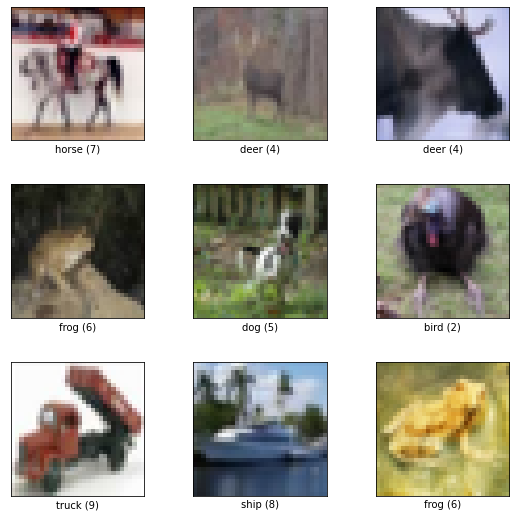

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

2021-09-27 16:06:17.362201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


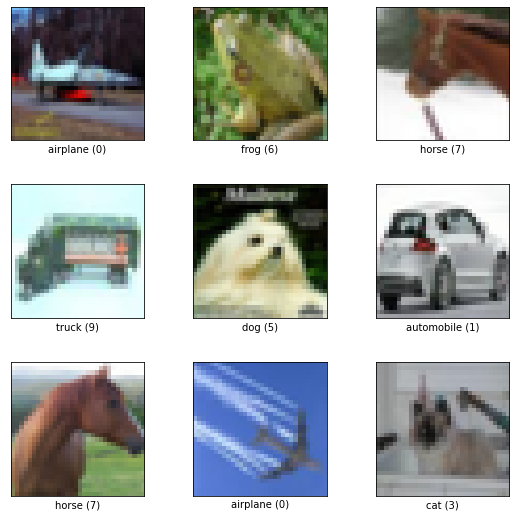

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. 블록 구성하기

### ResNet 기본 블록 만들기

In [95]:
# function for building ResNet Block
def build_resnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1, 
                       is_50=False):

    # 입력 레이어
    x = input_layer

    # ResNet-34
    if is_50==False:
        for i in range(num_cnn):
            if i == 0 and block_num > 0:
                shortcut = keras.layers.Conv2D(filters=channel, 
                                               kernel_size=(1,1), 
                                               kernel_initializer='he_normal', 
                                               padding='same', 
                                               strides=2)(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        strides=2,
                                        name=f'stage_{block_num+2}_{i+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_2')(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
                
            else:
                shortcut = x
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_2')(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
                
    # ResNet-50
    else:
        for i in range(num_cnn):
            if i == 0 and block_num > 0:
                shortcut = keras.layers.Conv2D(filters=channel*4, 
                                               kernel_size=(1,1), 
                                               kernel_initializer='he_normal', 
                                               padding='same', 
                                               strides=2)(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        strides=2)(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel*4, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
                
            else:
                shortcut = keras.layers.Conv2D(filters=channel*4, 
                                               kernel_size=(3,3), 
                                               kernel_initializer='he_normal', 
                                               padding='same')(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel*4, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)

    return x

In [105]:
# 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    output = input_layer
    output = keras.layers.Conv2D(64, 
                                 (7,7), 
                                 kernel_initializer='he_normal', 
                                 padding='same', 
                                 strides=2, 
                                 name='conv2d_15')(output)
    output = keras.layers.BatchNormalization(name='batch_normalization_13')(output)
    output = keras.layers.Activation('relu')(output)                                         
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn, 
                                    channel=channel,
                                    block_num=i, 
                                    is_50=is_50)
        
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(10, activation='relu', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, 
                        outputs=output)
    
    return model

## 3. ResNet Complete Model

### ResNet-34

In [35]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_139 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

### ResNet-50

In [106]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_46[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_830 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
___________________________________________________________________________________________

## 4. 일반 네트워크(plain network) 만들기

In [107]:
def build_plainnet_block(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1, 
                       is_50=False):

    # 입력 레이어
    x = input_layer

    # PlainNet-34
    if is_50==False:
        for i in range(num_cnn):
            if i == 0 and block_num > 0:
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        strides=2,
                                        name=f'stage_{block_num+2}_{i+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_2')(x)
                x = keras.layers.Activation(activation='relu')(x)
                
            else:
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv1')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_1')(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        name=f'stage_{block_num+2}_{i+1}_conv2')(x)
                x = keras.layers.BatchNormalization(name=f'stage_{block_num+2}_bn{i+1}_2')(x)
                x = keras.layers.Activation(activation='relu')(x)
                
    # PlainNet-50
    else:
        for i in range(num_cnn):
            if i == 0 and block_num > 0:
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same', 
                                        strides=2)(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel*4, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(activation='relu')(x)
                
            else:
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3,3), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation('relu')(x)
                
                x = keras.layers.Conv2D(filters=channel*4, 
                                        kernel_size=(1,1), 
                                        kernel_initializer='he_normal', 
                                        padding='same')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(activation='relu')(x)

    return x

In [109]:
# 모델 자체를 생성하는 함수입니다.
def build_plainnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    output = input_layer
    output = keras.layers.Conv2D(64, 
                                 (7,7), 
                                 kernel_initializer='he_normal', 
                                 padding='same', 
                                 strides=2, 
                                 name='conv2d_15')(output)
    output = keras.layers.BatchNormalization(name='batch_normalization_13')(output)
    output = keras.layers.Activation('relu')(output)                                         
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn, 
                                    channel=channel,
                                    block_num=i, 
                                    is_50=is_50)
        
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(10, activation='relu', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, 
                        outputs=output)
    
    return model

### PlainNet-34

In [110]:
plainnet_34 = build_plainnet(input_shape=(32, 32,3), is_50=False)
plainnet_34.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_47[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_879 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
___________________________________________________________________________________________

### PlainNet-50

In [111]:
plainnet_50 = build_plainnet(input_shape=(32, 32,3), is_50=True)
plainnet_50.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_48[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_912 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
___________________________________________________________________________________________

## 5. ResNet-50 vs Plain-50, ResNet-34 vs Plain-34

### Ablation Study


In [116]:
BATCH_SIZE = 256
EPOCH = 20

In [117]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [118]:
# ResNet-34 Train
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


2021-09-27 20:22:39.450389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 2.6870 - accuracy: 0.2011

2021-09-27 20:23:06.027676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 30s 359ms/step - loss: 2.6870 - accuracy: 0.2011 - val_loss: 2.9489 - val_accuracy: 0.2148
Epoch 2/20
72/72 [==============================] - 25s 348ms/step - loss: 2.7778 - accuracy: 0.2105 - val_loss: 2.9240 - val_accuracy: 0.2036
Epoch 3/20
72/72 [==============================] - 25s 351ms/step - loss: 2.7002 - accuracy: 0.2167 - val_loss: 2.8315 - val_accuracy: 0.2153
Epoch 4/20
72/72 [==============================] - 25s 347ms/step - loss: 2.7593 - accuracy: 0.2254 - val_loss: 2.9180 - val_accuracy: 0.2040
Epoch 5/20
72/72 [==============================] - 25s 351ms/step - loss: 2.7480 - accuracy: 0.2355 - val_loss: 3.1124 - val_accuracy: 0.2300
Epoch 6/20
72/72 [==============================] - 25s 351ms/step - loss: 2.8480 - accuracy: 0.2391 - val_loss: 3.5069 - val_accuracy: 0.2235
Epoch 7/20
72/72 [==============================] - 25s 346ms/step - loss: 2.8352 - accuracy: 0.2419 - val_loss: 2.9820 - val_accuracy: 0.2717
Epoch 8/20

In [119]:
# Plain-34 Train
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


2021-09-27 20:31:12.487154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 5.2181 - accuracy: 0.1139

2021-09-27 20:31:38.364281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 30s 364ms/step - loss: 5.2181 - accuracy: 0.1139 - val_loss: 2.9771 - val_accuracy: 0.1163
Epoch 2/20
72/72 [==============================] - 25s 352ms/step - loss: 2.7850 - accuracy: 0.1432 - val_loss: 2.9245 - val_accuracy: 0.1237
Epoch 3/20
72/72 [==============================] - 26s 356ms/step - loss: 2.5705 - accuracy: 0.1586 - val_loss: 3.2107 - val_accuracy: 0.1398
Epoch 4/20
72/72 [==============================] - 26s 359ms/step - loss: 2.6025 - accuracy: 0.1765 - val_loss: 3.0073 - val_accuracy: 0.1623
Epoch 5/20
72/72 [==============================] - 220s 3s/step - loss: 2.6308 - accuracy: 0.1845 - val_loss: 2.8740 - val_accuracy: 0.1849
Epoch 6/20
72/72 [==============================] - 25s 348ms/step - loss: 2.6575 - accuracy: 0.1984 - val_loss: 2.9944 - val_accuracy: 0.1943
Epoch 7/20
72/72 [==============================] - 25s 349ms/step - loss: 2.6480 - accuracy: 0.2189 - val_loss: 2.8482 - val_accuracy: 0.2180
Epoch 8/20
7

In [120]:
# ResNet-50 Train
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


2021-09-27 20:42:58.731437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 5.3321 - accuracy: 0.1085

2021-09-27 20:45:53.087400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 183s 2s/step - loss: 5.3321 - accuracy: 0.1085 - val_loss: 2.4206 - val_accuracy: 0.1011
Epoch 2/20
72/72 [==============================] - 174s 2s/step - loss: 2.4753 - accuracy: 0.1140 - val_loss: 2.3277 - val_accuracy: 0.0964
Epoch 3/20
72/72 [==============================] - 168s 2s/step - loss: 2.4592 - accuracy: 0.1203 - val_loss: 2.4930 - val_accuracy: 0.0964
Epoch 4/20
72/72 [==============================] - 169s 2s/step - loss: 2.4757 - accuracy: 0.1224 - val_loss: 2.7636 - val_accuracy: 0.1085
Epoch 5/20
72/72 [==============================] - 169s 2s/step - loss: 2.4800 - accuracy: 0.1255 - val_loss: 2.5330 - val_accuracy: 0.1168
Epoch 6/20
72/72 [==============================] - 170s 2s/step - loss: 2.4678 - accuracy: 0.1281 - val_loss: 2.4638 - val_accuracy: 0.1341
Epoch 7/20
72/72 [==============================] - 170s 2s/step - loss: 2.5015 - accuracy: 0.1348 - val_loss: 2.4748 - val_accuracy: 0.1471
Epoch 8/20
72/72 [======

In [121]:
# Plain-50 Train
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


2021-09-27 22:02:29.586055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 5.3614 - accuracy: 0.1033

2021-09-27 22:05:29.925796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 190s 3s/step - loss: 5.3614 - accuracy: 0.1033 - val_loss: 2.3482 - val_accuracy: 0.1072
Epoch 2/20
72/72 [==============================] - 188s 3s/step - loss: 2.4477 - accuracy: 0.1111 - val_loss: 2.3080 - val_accuracy: 0.1133
Epoch 3/20
72/72 [==============================] - 185s 3s/step - loss: 2.4173 - accuracy: 0.1187 - val_loss: 2.3260 - val_accuracy: 0.0981
Epoch 4/20
72/72 [==============================] - 178s 2s/step - loss: 2.4467 - accuracy: 0.1219 - val_loss: 2.3983 - val_accuracy: 0.1216
Epoch 5/20
72/72 [==============================] - 174s 2s/step - loss: 2.4268 - accuracy: 0.1230 - val_loss: 2.4029 - val_accuracy: 0.1163
Epoch 6/20
72/72 [==============================] - 175s 2s/step - loss: 2.5076 - accuracy: 0.1223 - val_loss: 2.5703 - val_accuracy: 0.1241
Epoch 7/20
72/72 [==============================] - 174s 2s/step - loss: 2.5739 - accuracy: 0.1292 - val_loss: 2.5733 - val_accuracy: 0.1246
Epoch 8/20
72/72 [======

### 시각화

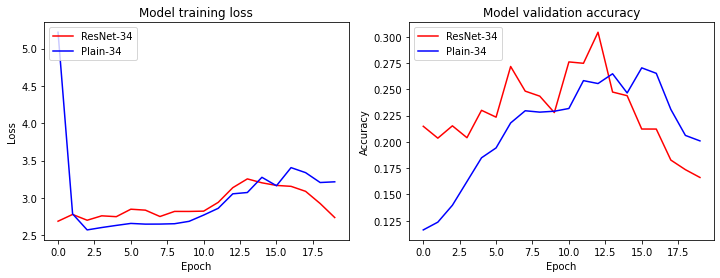

In [122]:
#ResNet-34 VS Plain-34 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plainnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plainnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.show()

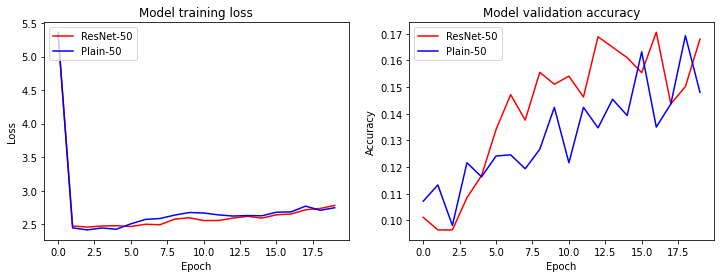

In [124]:
#ResNet-50 VS Plain-50 시각화

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plainnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')

plt.show()